### Install Vertex AI SDK for Python and other required packages


In [ ]:
pip install --upgrade --force-reinstall google-cloud-aiplatform 'kfp<2.0' pydantic ydata-profiling


In [1]:
! pip3 install --upgrade --quiet google-cloud-aiplatform \
                                 'kfp<2.0'

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [2]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [3]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project. Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [4]:
PROJECT_ID = "noted-casing-443608-r1"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Enable Cloud services used throughout this notebook.

Run the cell below to the enable Compute Engine, Container Registry, and Vertex AI services.

In [5]:
!gcloud services enable compute.googleapis.com         \
                       containerregistry.googleapis.com  \
                       aiplatform.googleapis.com

Operation "operations/acat.p2-83022982256-b473c86a-8a6b-4179-9478-09861e2a5ecf" finished successfully.


### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [6]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [7]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://your-bucket-name-noted-casing-443608-r1-unique/...


### Service Account

Use a service account to create Vertex AI Pipeline jobs.

If you don't want to use your project's Compute Engine service account, set `SERVICE_ACCOUNT` to another service account ID.

In [12]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [13]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

Service Account: 83022982256-compute@developer.gserviceaccount.com


#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [14]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Import libraries and define constants

Import required libraries.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
# We'll use this beta library for metadata querying
from google.cloud import aiplatform, aiplatform_v1beta1
from google.cloud.aiplatform import pipeline_jobs
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import (Artifact, Dataset, Input, Metrics, Model, Output,
                        OutputPath, component)

Define some constants

In [16]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin
REGION = "us-central1"

PIPELINE_ROOT = f"{BUCKET_URI}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


'gs://your-bucket-name-noted-casing-443608-r1-unique/pipeline_root/'

### Initialize Vertex AI SDK for Python

In [17]:
aiplatform.init(project=PROJECT_ID, location=LOCATION)

## Concepts

To better understand [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) and [Vertex AI ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata), here’re some relevant concepts:


### Pipeline Run
The term “run” refers to a single execution of your pipeline in Vertex AI Pipelines, during which artifacts, metrics, and associated metadata are generated.

### Artifact

An artifact is a resource generated by your pipeline. Artifacts can be datasets, models, endpoints, or custom resources defined in your pipeline.

### Metric

A metric is a way to measure the performance of your pipeline runs and artifacts. For example, a metric can be the accuracy of a classification model artifact created in your pipeline, or the size of the dataset used to train your model.

### Metadata

Metadata describes the artifacts and metrics generated by your pipeline runs. Metadata on a model, for example, includes the URL of the model artifacts, its name, and the time it was created.

## Creating a 3-step pipeline with custom components

The focus of this lab is on understanding metadata from pipeline runs. To do that, you need a pipeline to run on Vertex AI Pipelines, which is where you start. Here, you define a 3-step pipeline with the following custom components:

* `get_dataframe`: Retrieve data from a BigQuery table and convert it into a pandas DataFrame.
* `train_sklearn_model`: Use the pandas DataFrame to train and export a scikit-learn model, along with some metrics.
* `deploy_model`: Deploy the exported scikit-learn model to an endpoint in Vertex AI.

### Create and define Python function based components

First, define the `get_dataframe` component with the code below. This component does the following:
* Creates a reference to a BigQuery table using the BigQuery client library
* Downloads the BigQuery table and converts it to a shuffled pandas DataFrame
* Exports the DataFrame to a CSV file

In [18]:
@component(
    packages_to_install=["google-cloud-bigquery[pandas]", "pyarrow"],
    base_image="python:3.10",
    output_component_file="create_dataset.yaml",
)
def get_dataframe(
    project_id: str, bq_table: str, output_data_path: OutputPath("Dataset")
):
    from google.cloud import bigquery

    bqclient = bigquery.Client(project=project_id)
    table = bigquery.TableReference.from_string(bq_table)
    rows = bqclient.list_rows(table)
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )
    dataframe = dataframe.sample(frac=1, random_state=2)
    dataframe.to_csv(output_data_path)

Next, create a component to train a scikit-learn model. This component does the following:
* Imports a CSV as a pandas DataFrame.
* Splits the DataFrame into train and test sets.
* Trains a scikit-learn model.
* Logs metrics from the model.
* Saves the model artifacts as a local `model.joblib` file.

In [19]:
@component(
    packages_to_install=["scikit-learn==1.2", "pandas", "joblib", "numpy==1.26.4"],
    base_image="python:3.10",
    output_component_file="beans_model_component.yaml",
)
def sklearn_train(
    dataset: Input[Dataset], metrics: Output[Metrics], model: Output[Model]
):
    import pandas as pd
    from joblib import dump
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier

    df = pd.read_csv(dataset.path)
    labels = df.pop("Class").tolist()
    data = df.values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(data, labels)

    skmodel = DecisionTreeClassifier()
    skmodel.fit(x_train, y_train)
    score = skmodel.score(x_test, y_test)
    print("accuracy is:", score)

    metrics.log_metric("accuracy", (score * 100.0))
    metrics.log_metric("framework", "Scikit Learn")
    metrics.log_metric("dataset_size", len(df))
    dump(skmodel, model.path + ".joblib")

Finally, the last component  takes the trained model from the previous step, uploads the model to Vertex AI, and deploys it to an endpoint:

In [20]:
@component(
    packages_to_install=["google-cloud-aiplatform"],
    base_image="python:3.10",
    output_component_file="beans_deploy_component.yaml",
)
def deploy_model(
    model: Input[Model],
    project: str,
    region: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model],
):
    from google.cloud import aiplatform

    aiplatform.init(project=project, location=region)

    deployed_model = aiplatform.Model.upload(
        display_name="beans-model-pipeline",
        artifact_uri=model.uri.replace("model", ""),
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-2:latest",
    )
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    # Save data to the output params
    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name

### Define and compile the pipeline

In [21]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="mlmd-pipeline",
)
def pipeline(
    bq_table: str,
    output_data_path: str,
    project: str,
    region: str,
):
    dataset_task = get_dataframe(project, bq_table)

    model_task = sklearn_train(dataset_task.output)

    deploy_model(model=model_task.outputs["model"], project=project, region=region)

The following generates a JSON file that is then used to run the pipeline:

In [22]:
compiler.Compiler().compile(pipeline_func=pipeline, package_path="mlmd_pipeline.json")

/opt/conda/lib/python3.10/site-packages/kfp/v2/compiler/compiler.py:1290: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  warnings.warn(


### Initiate pipeline runs

First, define a timestamp to use as your pipeline job IDs.

Then for each run, create an instance of `PipelineJob` from the `pipeline_jobs` module.
 For each instance provide the following details:

* `display_name` : Human-readable name for the pipeline job.
* `template_path` : This specifies the path to the pipeline template file in JSON format, which contains the pipeline's configuration and structure created in the previous steps.
* `job_id` : This sets a unique identifier for the job.
* `parameter_values` : This dictionary contains key-value pairs for the parameters required by the pipeline which are metioned during pipeline definition.
    * `bq_table` :  Specifies the BigQuery table to use.
    * `output_data_path` : Defines the path for the output data file.
    * `project` : Specifies the Google Cloud project ID.
    * `region` : Defines the region where the pipeline will run.
* enable_caching : When set to `True`, caching is enabled for the pipeline run. This lets the system reuse previous results, if the same job has been executed before with identical parameters, thereby saving time and resources

In [23]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

Create a pipeline run using the smaller version beans dataset.

In [24]:
run1 = pipeline_jobs.PipelineJob(
    display_name="mlmd-pipeline",
    template_path="mlmd_pipeline.json",
    job_id="mlmd-pipeline-small-{}".format(TIMESTAMP),
    parameter_values={
        "bq_table": "sara-vertex-demos.beans_demo.small_dataset",
        "output_data_path": "data.csv",
        "project": PROJECT_ID,
        "region": REGION,
    },
    enable_caching=True,
)

Next, create another pipeline run using a larger version of the same dataset.

In [25]:
run2 = pipeline_jobs.PipelineJob(
    display_name="mlmd-pipeline",
    template_path="mlmd_pipeline.json",
    job_id="mlmd-pipeline-large-{}".format(TIMESTAMP),
    parameter_values={
        "bq_table": "sara-vertex-demos.beans_demo.large_dataset",
        "output_data_path": "data.csv",
        "project": PROJECT_ID,
        "region": REGION,
    },
    enable_caching=True,
)

Finally, kick off pipeline executions for both runs. It's best to do this in two separate notebook cells so you can see the output for each run.

In [26]:
run1.submit()

Creating PipelineJob
PipelineJob created. Resource name: projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20241226052552
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20241226052552')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlmd-pipeline-small-20241226052552?project=83022982256


Then, kick off the second run:

In [27]:
run2.submit()

Creating PipelineJob
PipelineJob created. Resource name: projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20241226052552
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20241226052552')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlmd-pipeline-large-20241226052552?project=83022982256


After running this cell, there is a link to view each pipeline in the Google Cloud console. Open that link to get more details about your pipeline.

**These pipeline runs will take 10-15 minutes to complete.**

## Comparing pipeline runs

Once both the pipelines run successfully, you're ready to take a closer look at pipeline metrics using the Vertex AI SDK for Python.


Use `aiplatform.get_pipeline_df()` method to retrieve the metadata for the last two runs of the pipeline. Then, load it into a Pandas DataFrame. 
The `pipeline` parameter specifies the name of your pipeline as defined in the pipeline configuration, which in this case is *mlmd-pipeline*.

In [28]:
df = aiplatform.get_pipeline_df(pipeline="mlmd-pipeline")
print(df)

   pipeline_name                            run_name param.input:region  \
0  mlmd-pipeline  mlmd-pipeline-large-20241226052552        us-central1   
1  mlmd-pipeline  mlmd-pipeline-small-20241226052552        us-central1   

                         param.input:bq_table     param.input:project  \
0  sara-vertex-demos.beans_demo.large_dataset  noted-casing-443608-r1   
1  sara-vertex-demos.beans_demo.small_dataset  noted-casing-443608-r1   

                     param.vmlmd_lineage_integration  \
0  {'pipeline_run_component': {'location_id': 'us...   
1  {'pipeline_run_component': {'project_id': 'not...   

  param.input:output_data_path  
0                     data.csv  
1                     data.csv  


You’ve only executed the pipeline twice here, but you can imagine how many metrics you'd have with more executions. Next, create a custom visualization with matplotlib to see the relationship between the model accuracy and the amount of data used for training. Run the following to generate a graph:

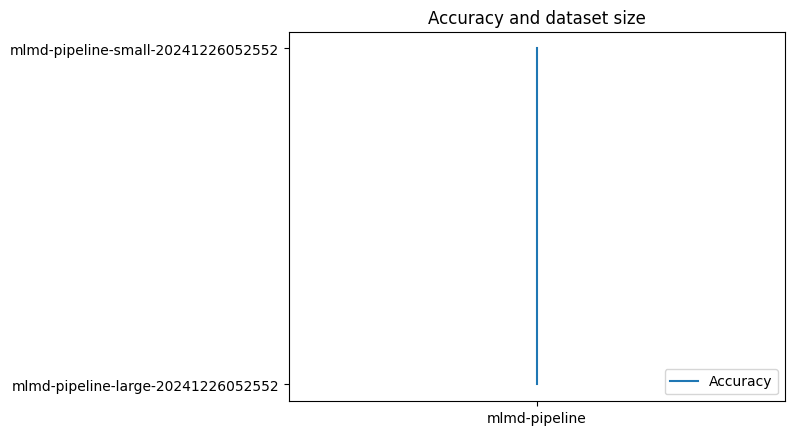

In [30]:
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Accuracy")  # Assuming the first two columns are the ones you need
plt.title("Accuracy and dataset size")
plt.legend(loc=4)
plt.show()


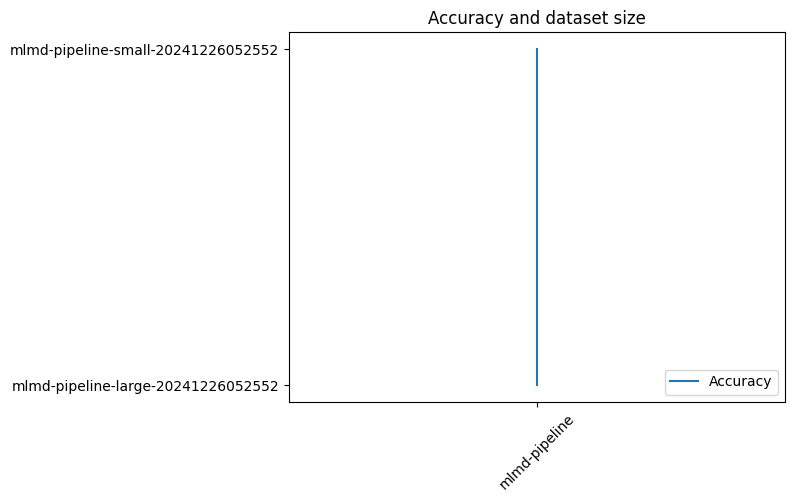

In [34]:
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Accuracy")
plt.title("Accuracy and dataset size")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.legend(loc=4)
plt.show()

## Querying pipeline metrics

In addition to creating a DataFrame of all pipeline metrics, you can programmatically query artifacts created in your ML system. From there you can create a custom dashboard or let others in your organizaiton get details on specific artifacts.

### Getting all Model artifacts

To query artifacts in this way, create a `MetadataServiceClient`:

In [35]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
metadata_client = aiplatform_v1beta1.MetadataServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

Next, make a `list_artifacts` request to that endpoint and pass a filter indicating which artifacts you'd like in your response. First, let's get all the artifacts in the project that are **models**. To do that, run the following in your notebook:

In [36]:
MODEL_FILTER = 'schema_title = "system.Model"'
artifact_request = aiplatform_v1beta1.ListArtifactsRequest(
    parent="projects/{}/locations/{}/metadataStores/default".format(PROJECT_ID, REGION),
    filter=MODEL_FILTER,
)
model_artifacts = metadata_client.list_artifacts(artifact_request)

The resulting `model_artifacts` response contains an iterable object for each model artifact in your project, along with associated metadata for each model.

### Filtering objects and displaying in a DataFrame

Next, get all artifacts created after August 10, 2021 that are in `LIVE` state. 

In [37]:
LIVE_FILTER = 'create_time > "2021-08-10T00:00:00-00:00" AND state = LIVE'
artifact_req = {
    "parent": "projects/{}/locations/{}/metadataStores/default".format(
        PROJECT_ID, REGION
    ),
    "filter": LIVE_FILTER,
}
live_artifacts = metadata_client.list_artifacts(artifact_req)

Then, display the results in a DataFrame:

In [38]:
data = {"uri": [], "createTime": [], "type": []}

for i in live_artifacts:
    data["uri"].append(i.uri)
    data["createTime"].append(i.create_time)
    data["type"].append(i.schema_title)

df = pd.DataFrame.from_dict(data)
print(df)

                                                 uri  \
0  gs://your-bucket-name-noted-casing-443608-r1-u...   
1  gs://your-bucket-name-noted-casing-443608-r1-u...   

                        createTime            type  
0 2024-12-26 05:26:02.195000+00:00  system.Dataset  
1 2024-12-26 05:26:00.522000+00:00  system.Dataset  


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

If you don't want to delete the project, do the following to clean up the resources you used:

* If you used Vertex AI Workbench notebooks to run this, stop or delete the notebook instance.

* The pipeline runs you executed deployed endpoints in Vertex AI. Navigate to the [Google Cloud console](https://console.cloud.google.com/vertex-ai/endpoints) to delete those endpoints.

* Delete the [Cloud Storage bucket](https://console.cloud.google.com/storage/browser/) you created.

Alternatively, you can execute the below cell to clean up the resources used in this notebook.

In [39]:
# delete pipelines
try:
    run1.delete()
    run2.delete()
except Exception as e:
    print(e)

# undeploy model from endpoints
endpoints = aiplatform.Endpoint.list(
    filter='display_name="beans-model-pipeline_endpoint"'
)
for endpoint in endpoints:
    deployed_models = endpoint.list_models()
    for deployed_model in deployed_models:
        endpoint.undeploy(deployed_model_id=deployed_model.id)
    # delete endpoint
    endpoint.delete()

# delete model
model_ids = aiplatform.Model.list(filter='display_name="beans-model-pipeline"')
for model_id in model_ids:
    model = aiplatform.Model(model_name=model_id.resource_name)
    model.delete()

# delete locally generated files
! rm -rf beans_deploy_component.yaml beans_model_component.yaml create_dataset.yaml mlmd_pipeline.json

# delete cloud storage bucket
delete_bucket = False  # set True for deletion
if delete_bucket:
    ! gsutil rm -rf {BUCKET_URI}

Deleting PipelineJob : projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20241226052552
PipelineJob deleted. . Resource name: projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20241226052552
Deleting PipelineJob resource: projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20241226052552
Delete PipelineJob backing LRO: projects/83022982256/locations/us-central1/operations/7566592078914781184
PipelineJob resource projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-small-20241226052552 deleted.
Deleting PipelineJob : projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20241226052552
PipelineJob deleted. . Resource name: projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20241226052552
Deleting PipelineJob resource: projects/83022982256/locations/us-central1/pipelineJobs/mlmd-pipeline-large-20241226052552
Delete PipelineJob backing LRO: projects/83